In [7]:
import math

import torch
import torch.nn.functional as F
import trimesh
#from trimesh.util import triangle_strips_to_faces

from src.util import make_faces
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random


torch.set_printoptions( sci_mode=False)

torch.Size([4, 4])


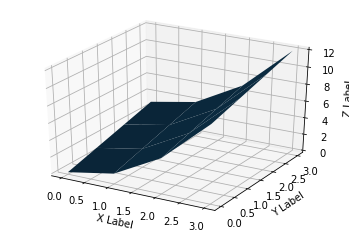

In [3]:
def fun(x, y):
    return x**2 + y

xs = ys = torch.arange(0.0, 4.0, 1)
x, y = torch.meshgrid(xs, ys)

zs = np.array(fun(np.ravel(x.numpy()), np.ravel(y.numpy())))
z = torch.tensor(zs.reshape(x.shape))
print(x.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [5]:
vertices = torch.stack((x, y, z), dim=-1).reshape(-1, 3)
print(vertices.shape)
faces = make_faces(4, 4)
faces

torch.Size([16, 3])


array([[ 0,  4,  1],
       [ 5,  1,  4],
       [ 1,  5,  2],
       [ 6,  2,  5],
       [ 2,  6,  3],
       [ 7,  3,  6],
       [ 4,  8,  5],
       [ 9,  5,  8],
       [ 5,  9,  6],
       [10,  6,  9],
       [ 6, 10,  7],
       [11,  7, 10],
       [ 8, 12,  9],
       [13,  9, 12],
       [ 9, 13, 10],
       [14, 10, 13],
       [10, 14, 11],
       [15, 11, 14]])

In [6]:
import os
from collections import OrderedDict
import torch
import torch.nn.functional as F
from src.util import (
    make_faces,    
)    

def vertex_tris(faces):
    res = [[] for _ in range(faces.max()+1)]
    for fid, face in enumerate(faces):        
        for vid in face:
            res[vid].append(fid)        
    return res

def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):        
        weight = 1. #/ len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

class VertexNormals(torch.nn.Module):
    
    def __init__(self, opt, load=True):
        super().__init__()
        self.size = opt.data_patch_size
        self.path = os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.data_patch_size))
        if load and os.path.exists(self.path):
            trimap = torch.load(self.path)
        else:
            trimap = self.make_trimap(opt.data_patch_size)
            torch.save(trimap, self.path)
        self.assign_trimap(trimap)
    
    def assign_trimap(self,  trimap):
        self.register_buffer('faces',  trimap['faces'])
        self.register_buffer('vert_tri_indices', trimap['vert_tri_indices'])
        self.register_buffer('vert_tri_weights', trimap['vert_tri_weights'])

    def __call__(self, vrt):
        face_normals = self.get_face_normals(vrt)
        bs = face_normals.size(0)
        r, c = self.vert_tri_indices.shape
        fn_group = face_normals.index_select(1, 
            self.vert_tri_indices.flatten()).reshape(bs, r, c, 3)
        weighted_fn_group = fn_group * self.vert_tri_weights    
        vertex_normals = weighted_fn_group.sum(dim=-2)
        return F.normalize(vertex_normals, p=2, dim=-1)
    
    def get_face_normals(self, vrt):
        faces = self.faces
        v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
        v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
        face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
        return face_normals
    
    def __repr__(self):
        return f'VertexNormals: size: {self.size} path: {self.path}'
    
    def make_trimap(self, size):
        faces = torch.tensor(make_faces(size, size))
        vert_tri_indices, vert_tri_weights = vertex_tri_maps(faces)
        return OrderedDict(OrderedDict([
          ('vert_tri_indices', vert_tri_indices),
          ('vert_tri_weights', vert_tri_weights),
          ('faces', faces),
        ]))
    
from argparse import Namespace
#from src.vertex_normals import VertexNormals


opt = Namespace()
opt.data_dir = './data/'
opt.data_patch_size = 4
print(opt)
vn = VertexNormals(opt, load=False)
print(vn)

calc_mvn = vn(vertices[None])
calc_mvn

Namespace(data_dir='./data/', data_patch_size=4)
VertexNormals: size: 4 path: ./data/trimap_4.pth


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053],
         [-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [13]:
vertex_count = vertices.shape[0]
face_no = int(math.sqrt(vertex_count))
faces = make_faces(face_no, face_no)
calc_fn = vn.get_face_normals(vertices[None])
face_normals = calc_fn.squeeze().numpy() #mesh.face_normals
print(vertex_count, faces.shape, face_normals.shape)


mean_vertex_normals = trimesh.geometry.mean_vertex_normals(
    vertex_count,
    faces,
    face_normals
)
t1 = torch.tensor(mean_vertex_normals).float()
t1.reshape(face_no, face_no, 3)

16 (18, 3) (18, 3)


tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774]],

        [[-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053]],

        [[-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295]],

        [[-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [15]:
calc_mvn.reshape(face_no, face_no, 3)

tensor([[[-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774],
         [-0.5774, -0.5774,  0.5774]],

        [[-0.7071, -0.5000,  0.5000],
         [-0.7662, -0.4544,  0.4544],
         [-0.7662, -0.4544,  0.4544],
         [-0.8194, -0.4053,  0.4053]],

        [[-0.9266, -0.2660,  0.2660],
         [-0.9366, -0.2478,  0.2478],
         [-0.9366, -0.2478,  0.2478],
         [-0.9459, -0.2295,  0.2295]],

        [[-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925],
         [-0.9623, -0.1925,  0.1925]]])

In [16]:
torch.allclose(t1, calc_mvn.reshape_as(t1))

True

In [18]:
import stl

In [20]:
vertices.shape, faces.shape

(torch.Size([16, 3]), (18, 3))

In [21]:
stl_mesh = stl.mesh.Mesh.from_file('./data/plane3x3_.stl')
stl_mesh

In [25]:
stl_mesh.

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=uint16)

In [29]:
!pip install openmesh

     |████████████████████████████████| 9.1 MB 370 kB/s eta 0:00:01
  Created wheel for openmesh: filename=openmesh-1.1.6-cp38-cp38-linux_x86_64.whl size=621615 sha256=109bd0dee7556811977b8e4aef8d569af25b6ccc50290f6983430fc29effa51f
  Stored in directory: /home/bobi/.cache/pip/wheels/78/6a/70/327b3ed5b6bf75b8645c80981bfe29f375bdc6b3c01369ef2a
Successfully built openmesh


In [30]:
import openmesh as om


In [32]:
vertices, faces

(tensor([[ 0.,  0.,  0.],
         [ 0.,  1.,  1.],
         [ 0.,  2.,  2.],
         [ 0.,  3.,  3.],
         [ 1.,  0.,  1.],
         [ 1.,  1.,  2.],
         [ 1.,  2.,  3.],
         [ 1.,  3.,  4.],
         [ 2.,  0.,  4.],
         [ 2.,  1.,  5.],
         [ 2.,  2.,  6.],
         [ 2.,  3.,  7.],
         [ 3.,  0.,  9.],
         [ 3.,  1., 10.],
         [ 3.,  2., 11.],
         [ 3.,  3., 12.]]),
 array([[ 0,  4,  1],
        [ 5,  1,  4],
        [ 1,  5,  2],
        [ 6,  2,  5],
        [ 2,  6,  3],
        [ 7,  3,  6],
        [ 4,  8,  5],
        [ 9,  5,  8],
        [ 5,  9,  6],
        [10,  6,  9],
        [ 6, 10,  7],
        [11,  7, 10],
        [ 8, 12,  9],
        [13,  9, 12],
        [ 9, 13, 10],
        [14, 10, 13],
        [10, 14, 11],
        [15, 11, 14]]))

In [34]:
om_mesh = om.TriMesh(points=vertices.numpy(),
                     face_vertex_indices=faces)
om_mesh

In [40]:
om.write_mesh('./data/m4x4.ply',om_mesh)